In [1]:
pip install tensorflow-datasets


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: C:\Users\asus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### a. loading dan scaling data, dan pisahkan validation, training, dan testing

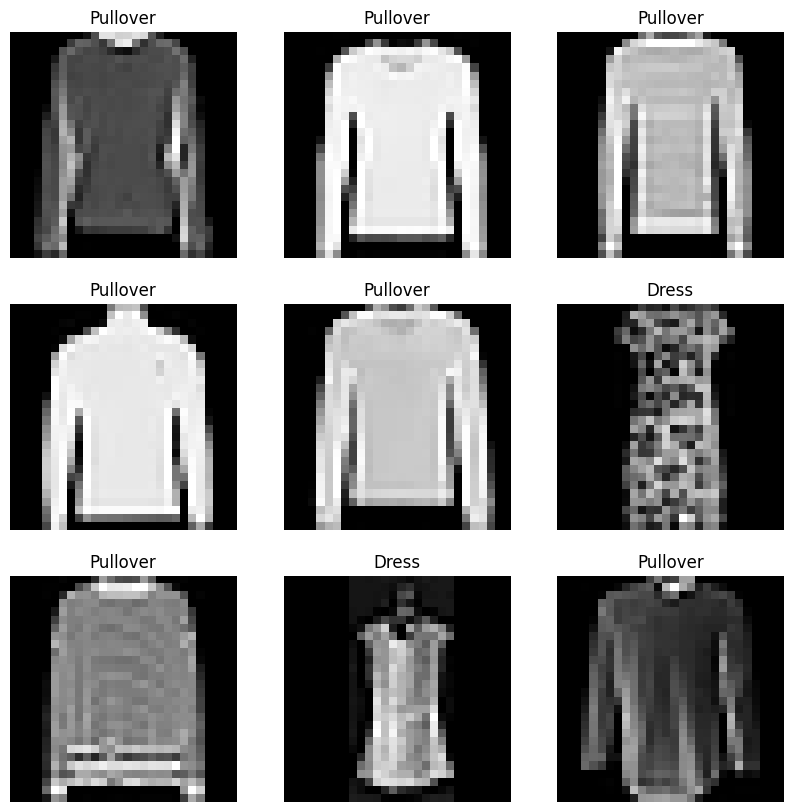

Training set size: 11200
Validation set size: 1400
Test set size: 1400


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Memuat dataset Fashion MNIST
ds = tfds.load('fashion_mnist', split='train+test', as_supervised=True)
ds = ds.filter(lambda img, label: tf.math.logical_or(tf.equal(label, 2), tf.equal(label, 3)))

# Fungsi untuk menskalakan data
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

# Terapkan fungsi skala ke dataset
ds = ds.map(scale)

# Tampilkan beberapa contoh data
def show_examples(dataset, classes):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(classes[label.numpy() - 2])  # Menggunakan offset -2 untuk menghindari indeks out of range
        plt.axis('off')
    plt.show()

classes = ['Pullover', 'Dress']
show_examples(ds, classes)

# Membagi dataset menjadi training, validation, dan test set
ds_size = len(list(ds))
train_size = int(0.8 * ds_size)
val_size = int(0.1 * ds_size)
test_size = ds_size - train_size - val_size

train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size + val_size)

# Buffer dan batch
batch_size = 32
train_ds = train_ds.shuffle(buffer_size=train_size).batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Tampilkan jumlah data di setiap set
print(f'Training set size: {train_size}')
print(f'Validation set size: {val_size}')
print(f'Test set size: {test_size}')

In [3]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: C:\Users\asus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### b. arsitektur baseline untuk Dimension Reduction dari dimensi 784 (28x28) menjadi dimensi 128

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
    348/Unknown 13s 12ms/step - loss: 2.6162

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 2.6154 - val_loss: 2.5193
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 2.4970 - val_loss: 2.5193
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 2.5028 - val_loss: 2.5193
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 2.4879 - val_loss: 2.5193
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 2.5207 - val_loss: 2.5193
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 2.4814 - val_loss: 2.5193
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 2.5152 - val_loss: 2.5193
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 2.4907 - val_loss: 2.5193
Epoch 9/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - loss: 2.5241 - val_loss: 2.5193
Epoch 10/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 2.5014 - val_loss: 2.5193
Epoch 11/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - loss: 2.5317 - val_loss: 2.5193
Original image shape: (28, 28), Reconstru

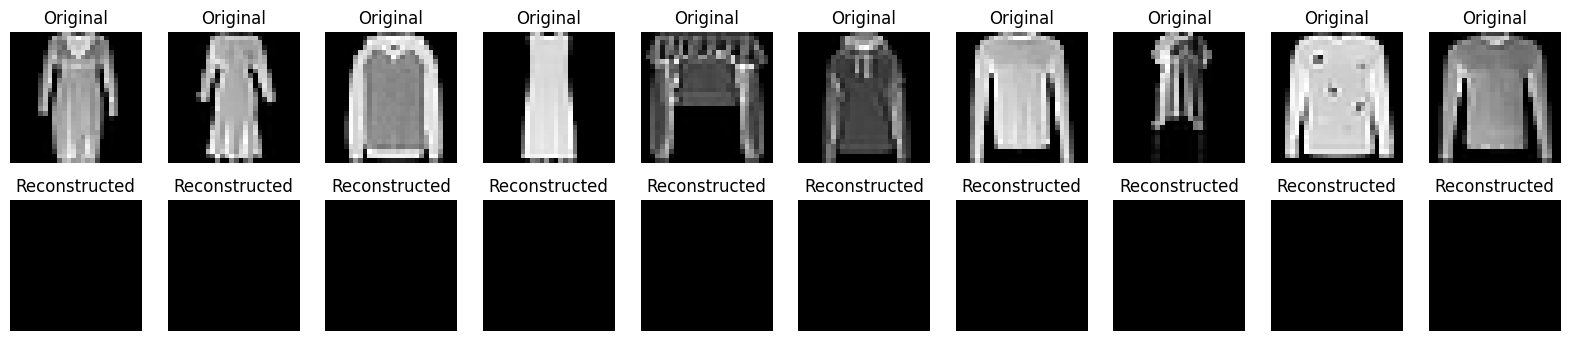

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Definisikan arsitektur Autoencoder
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(128, activation='relu')
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(7*7*32, activation='relu'),  # Sesuaikan dimensi untuk reshape yang benar
            layers.Reshape((7, 7, 32)),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Fungsi untuk menghitung SSIM
def compute_ssim(original, reconstructed):
    ssim_values = []
    for i in range(len(original)):
        original_img = original[i].numpy().squeeze()
        reconstructed_img = reconstructed[i].numpy().squeeze()
        print(f'Original image shape: {original_img.shape}, Reconstructed image shape: {reconstructed_img.shape}')
        if original_img.shape == reconstructed_img.shape:  # Pastikan dimensi sama
            ssim_value = ssim(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())
            print(f'SSIM for image {i}: {ssim_value}')
            ssim_values.append(ssim_value)
        else:
            print(f'Shape mismatch for image {i}: original shape {original_img.shape}, reconstructed shape {reconstructed_img.shape}')
    return np.mean(ssim_values) if ssim_values else float('nan')

# Inisialisasi dan kompilasi model
autoencoder = Autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Melatih model
history = autoencoder.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

# Evaluasi model
test_images = []
test_labels = []

for image, label in test_ds:
    test_images.append(image)
    test_labels.append(label)

test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)

reconstructed = autoencoder(test_images)
ssim_value = compute_ssim(test_images, reconstructed)

print(f'SSIM: {ssim_value}')

# Visualisasi beberapa hasil rekonstruksi
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Menampilkan gambar asli
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].numpy().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Menampilkan gambar hasil rekonstruksi
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

Approximate untuk modifikasi arsitektur Autoencoder :
1. Modifikasi arsitektur 
- Menambahkan lebih banyak lapisan pada encoder dan decoder.
- Menggunakan lapisan Batch Normalization dan Dropout untuk mencegah overfitting.
- Eksperimen dengan berbagai ukuran kernel dan jumlah filter pada lapisan Conv2D.

2. Tuning hyperparameter 
- Mengatur learning rate.
- Mengubah ukuran batch.
- Mengatur jumlah epoch dan penggunaan callback seperti EarlyStopping.

### c. modifikasi arsitektur autoencoder

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 2.6073 - val_loss: 2.5193
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 2.4805 - val_loss: 2.5193
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - loss: 2.5329 - val_loss: 2.5193
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 2.4813 - val_loss: 2.5193
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 2.4793 - val_loss: 2.5193
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - loss: 2.4936 - val_loss: 2.5193
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - loss: 2.4744 - val_loss: 2.5193
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 45s 112ms/step - loss: 2.5062 - val_loss: 2.5193
Epoch 9/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 51s 97ms/step - loss: 2.5126 - val_loss: 2.5193
Epoch 10/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 63s 143ms/step - loss: 2.5147 - val_loss: 2.5193
Epoch 11/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 67s 148ms/step - loss: 2.4893 - val_loss: 2.5193
SSIM: 0.06730707225552304


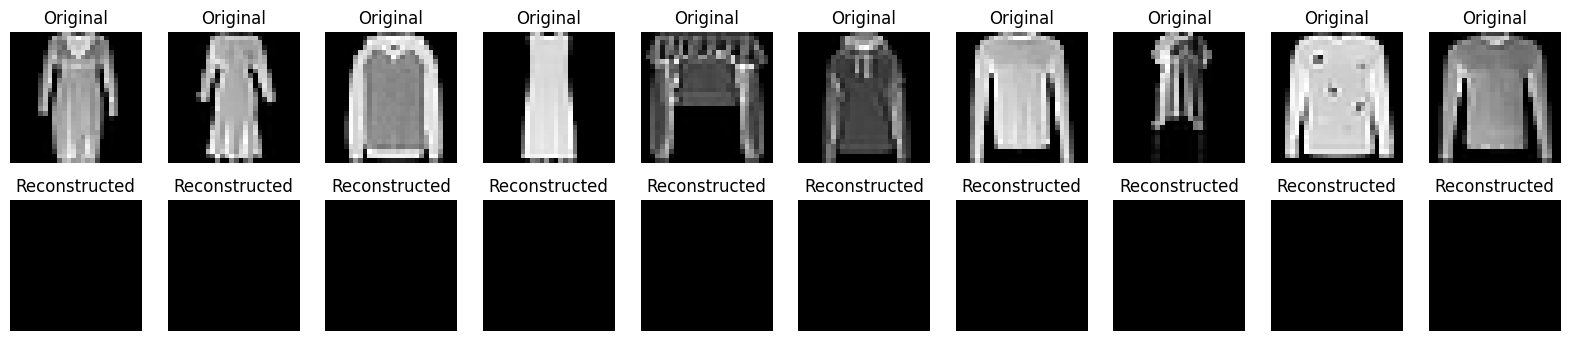

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Definisikan arsitektur Autoencoder yang dimodifikasi
class ModifiedAutoencoder(tf.keras.Model):
    def __init__(self):
        super(ModifiedAutoencoder, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu')
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(7*7*32, activation='relu'),
            layers.Reshape((7, 7, 32)),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Fungsi untuk menghitung SSIM
def compute_ssim(original, reconstructed):
    ssim_values = []
    for i in range(len(original)):
        original_img = original[i].numpy().squeeze()
        reconstructed_img = reconstructed[i].numpy().squeeze()
        if original_img.shape == reconstructed_img.shape:  # Pastikan dimensi sama
            ssim_value = ssim(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())
            ssim_values.append(ssim_value)
    return np.mean(ssim_values) if ssim_values else float('nan')

# Inisialisasi dan kompilasi model
autoencoder = ModifiedAutoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Melatih model
history = autoencoder.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

# Evaluasi model
test_images = []
test_labels = []

for image, label in test_ds:
    test_images.append(image)
    test_labels.append(label)

test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)

reconstructed = autoencoder(test_images)
ssim_value = compute_ssim(test_images, reconstructed)

print(f'SSIM: {ssim_value}')

# Visualisasi beberapa hasil rekonstruksi
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Menampilkan gambar asli
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].numpy().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Menampilkan gambar hasil rekonstruksi
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

In [6]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: C:\Users\asus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


alasan mengapa modifikasi arsitektur dan metode tuning hyperparameter saya lebih baik : 
1. Batch Normalization dan Dropout:
- Batch Normalization membantu dalam mempercepat pelatihan dan meningkatkan stabilitas model.
- Dropout digunakan untuk mencegah overfitting dengan mengabaikan beberapa neuron selama pelatihan.

2. Penambahan Lapisan:
- Penambahan lebih banyak lapisan convolutional dan dense memungkinkan model untuk belajar representasi yang lebih kompleks dan fitur tingkat tinggi dari data.

3. Hyperparameter Tuning:
- Tuning learning rate, ukuran batch, dan jumlah epoch membantu dalam menemukan kombinasi parameter yang optimal untuk meningkatkan performa model.
- Keras Tuner membantu dalam otomatisasi proses ini dengan mencoba berbagai kombinasi parameter dan memilih yang terbaik berdasarkan metrik yang dipilih.